# Analysis of Stan results (from process run on gcp), with constrained data

### Last updated June 1, 2018

In [1]:
!pip3 install pystan
#!pip3 install feather-format

You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
#import feather

In [3]:
import pandas as pd
import tabulate as tab
import numpy as np
import matplotlib as mpt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import sys
import pystan
import scipy
import pickle

pd.options.display.max_rows = 999
pd.options.display.max_columns = 50

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.facecolor'] ="white"
plt.rcParams['grid.color'] ="grey"
plt.rcParams['grid.linestyle'] = "dotted"
plt.rcParams["axes.labelsize"]= 14
#plt.rcParams['figure.savefig.dpi'] = 100
plt.rcParams['savefig.edgecolor'] = "#f2f2f2"
plt.rcParams['savefig.facecolor'] ="white"
plt.rcParams["figure.figsize"] = [15,8]
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['font.size'] = 14
greens = ['#66c2a4','#41ae76','#238b45','#006d2c','#00441b']
multi =['#66c2a4','#1f78b4','#a6cee3','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f']
#plt.rcParams["axes.color_cycle"] = multi



/usr/local/envs/py3env/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
import google.datalab.storage as storage
#get bucket names
from google.datalab import Context
import random, string
from io import BytesIO

### Functions

In [5]:
#import stan_helpers #get_cent_interval, post_sample

def get_cent_interval(sample, conf=.95):
	p=1-conf
	sample = np.sort(sample)
	n_sample = len(sample)
	low_ci = sample[round(n_sample*(p/2))]
	high_ci = sample[round(n_sample*(1-p/2))]
	return([low_ci, high_ci])


In [6]:
def summary_info(post_sample, lim=5):
	#post_sample = solar_params
	#lim=5
	"""
	Input extracted STAN model sample: post_sample
	lim - confidence interval ie lim = 5 => 95 central posterior interval
	"""

	params = []
	means = []
	medians = []
	modes = []
	low_ci = []
	high_ci = []
	for i in post_sample:
		param_sim = post_sample[i]
		if (param_sim.shape[0] == param_sim.size):
			params.append(i)
			means.append(np.mean(param_sim))
			medians.append(np.median(param_sim))
			n_samples = len(param_sim)
			n_tail = n_samples*(lim/100)/2
			param_sim=np.sort(param_sim)
			low_ci.append(param_sim[n_tail])
			high_ci.append(param_sim[n_samples-n_tail])
		else:
			for par_case in param_sim.T:
				params.append(i)
				means.append(np.mean(par_case))
				medians.append(np.median(par_case))
				modes.append(np.mode(parcase))
				n_samples = len(par_case)
				n_tail = n_samples*(lim/100)/2
				par_case=np.sort(par_case)
				low_ci.append(par_case[n_tail])
				high_ci.append(par_case[n_samples-n_tail])
	output = {"params":params,
		"means" : means,
		"medians" : medians,
		"low_ci" : low_ci,
		"high_ci" : high_ci}
	output = pd.DataFrame(output)
	return(output)

### Import Data

In [7]:
from google.datalab import Context
import random, string

In [8]:
solar_bucket = storage.Bucket('solar_commodities')
for obj in solar_bucket.objects():
  if obj.key.find('/') < 0:
    print(obj.key)

prod_csi.csv
solar_extr_200518.pkl
solar_extr_210518.pkl
solar_extr_210518_2.pkl
solar_extr_220518.pkl
solar_extr_230518.pkl
solar_extr_240518.pkl
solar_extr_250518.pkl
solar_extr_may18final.pkl
solar_extr_may18final2.pkl
solar_extr_may18final2_const.pkl


In [9]:
remote = solar_bucket.object("solar_extr_may18final2_const.pkl").read_stream()
solar_extr = pickle.load(BytesIO(remote))
print(solar_extr.keys())

odict_keys(['mu_cm', 'mu_b0', 'sigma_b1_mu', 'sigma_b1_sigma', 'sigma_b0', 'sigma_b1', 'sigma', 'sigma_cm', 'b0', 'b1', 'cm', 'mu1_lease', 'mu1_m', 'mu1_s', 'beta1_cost', 'beta1_size', 'beta1_fy', 'beta1_tmo', 'mu_b1', 'y_hat', 'lp__'])


## Convert to dataframe (and then to feather format?) to download

In [10]:
solar_vars = list(solar_extr.keys())
coef_keys = solar_vars[0:-2]


In [11]:
for par in coef_keys:
  parDF = pd.DataFrame(solar_extr[par])
  f = solar_bucket.object("posterior_const/"+par + ".csv")
  f.write_stream(parDF.to_csv(), 'text/csv')


## Analysis of data

In [13]:
mu_leaseDF = pd.DataFrame(solar_extr["mu1_lease"])
beta_costDF = pd.DataFrame(solar_extr["beta1_cost"])


beta_costDF.head()



,0,1
0,-0.000112,-0.000258
1,-0.000285,-0.001085
2,-0.000421,-0.000453
3,0.000150,-0.000992
4,-0.000441,-0.001696


In [14]:
mu_leaseDF.columns = ["mu_own", "mu_lease"]
beta_costDF.columns = ["beta_cost_own", "beta_cost_lease"]
#meta_muDF = pd.DataFrame(solar_extr["meta_mu"])
#meta_muDF.columns = ["meta_mu"]
#meta_mu_monDF = pd.DataFrame(solar_extr["meta_mu_mon"])

#county
#mu1_cDF = pd.DataFrame(solar_extr["mu1_c"])
mu1_sDF = pd.DataFrame(solar_extr["mu1_s"])

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


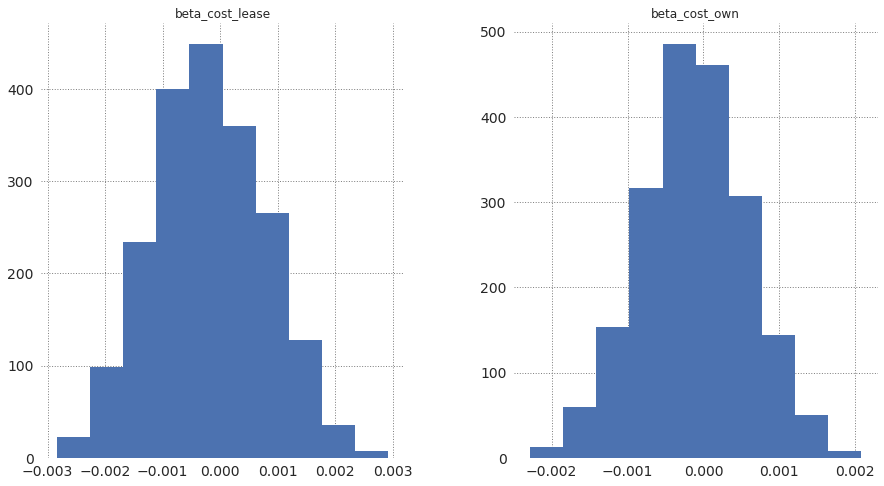

In [15]:
beta_costDF.hist()
plt.show()

In [16]:
beta_costDF.head()

,beta_cost_own,beta_cost_lease
0,-0.000112,-0.000258
1,-0.000285,-0.001085
2,-0.000421,-0.000453
3,0.000150,-0.000992
4,-0.000441,-0.001696


In [17]:
mu_leaseDF["mu_diff"] = mu_leaseDF["mu_lease"]-mu_leaseDF["mu_own"]
beta_costDF["beta_diff"] = beta_costDF["beta_cost_lease"]-beta_costDF["beta_cost_own"]

beta_costDF.head()
beta_pMore0 = beta_costDF.loc[beta_costDF.beta_diff>0, "beta_diff"].size/2000
mu_pMore0 = mu_leaseDF.loc[mu_leaseDF.mu_diff>0, "mu_diff"].size/2000

print("mu_pMore", mu_pMore0)
print("beta contrast", beta_pMore0)

mu_pMore 0.955
beta contrast 0.4625


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


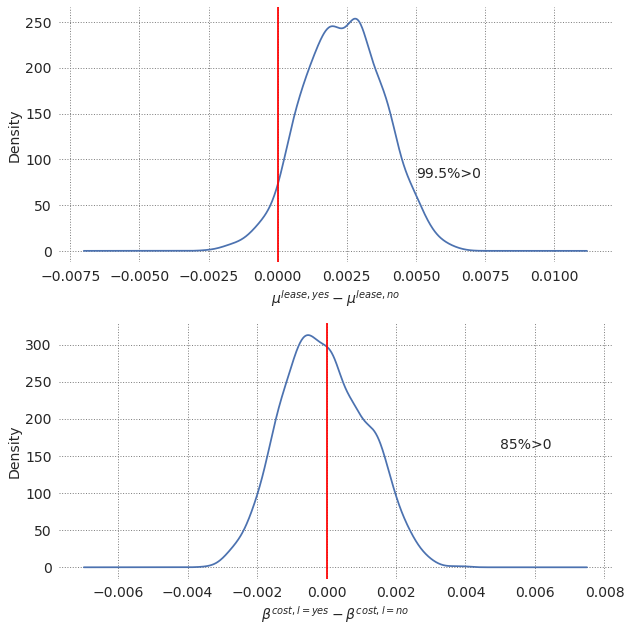

In [18]:





fig, ax = plt.subplots(2)
mu_leaseDF["mu_diff"].plot.density(ax=ax[0])
beta_costDF["beta_diff"].plot.density(ax=ax[1])
ax[0].axvline(x=0, color="red")
ax[1].axvline(x=0, color="red")
fig.set_size_inches(9,9)
#ax[0].set_xlim(-.005, .012)
#ax[1].set_xlim(-.005, .012)
ax[0].set_xlabel(r"$\mu^{lease,yes}- \mu^{lease,no}$")
ax[1].set_xlabel(r"$\beta^{cost,l=yes}- \beta^{cost,l=no}$")
ax[0].text(.005, 80, "99.5%>0")
ax[1].text(.005, 159, "85%>0")
plt.savefig("bayes_hypos_const.png", dpi=100)
plt.tight_layout()
plt.show()

In [19]:
mu_sectDF = pd.DataFrame(solar_extr["mu1_s"])

In [20]:
mu_sectDF.columns = ["Commercial", "Residential", "Government", "Non-profit"]

In [21]:
mu_sectDF["com-res"] = mu_sectDF["Commercial"]-mu_sectDF["Residential"]

In [22]:
mu_sectDF["gov-res"] = mu_sectDF["Government"]-mu_sectDF["Residential"]

In [23]:
mu_sectDF["npr-res"] = mu_sectDF["Non-profit"]-mu_sectDF["Residential"]

In [24]:
sect_com_pMore0 = mu_sectDF.loc[mu_sectDF["com-res"]>0, "com-res"].size/2000
sect_gov_pMore0 = mu_sectDF.loc[mu_sectDF["gov-res"]>0, "gov-res"].size/2000
sect_npr_pMore0 = mu_sectDF.loc[mu_sectDF["npr-res"]>0, "npr-res"].size/2000



print(sect_com_pMore0, sect_gov_pMore0, sect_npr_pMore0)


0.7795 0.918 0.7415


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


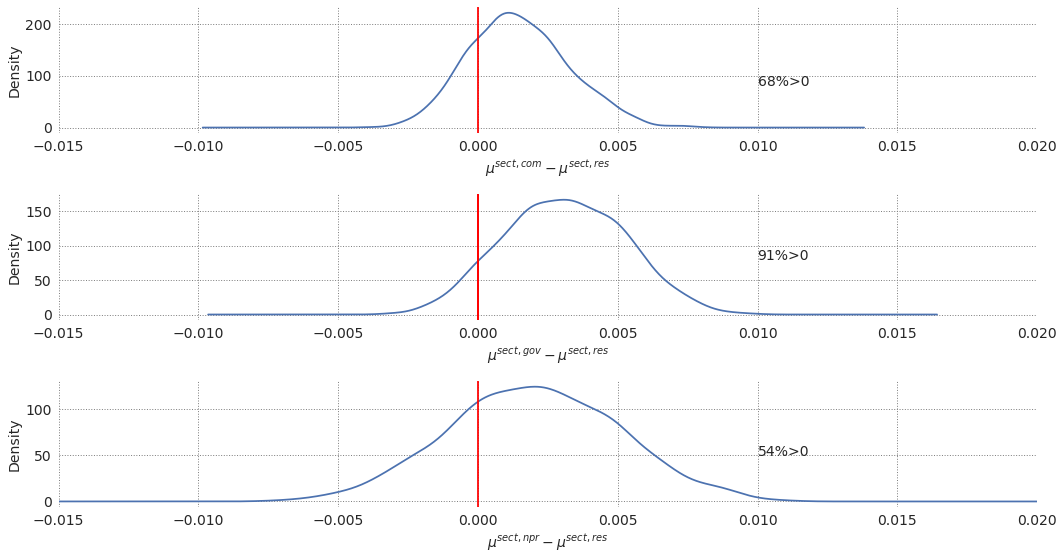

In [25]:
fig, ax = plt.subplots(3)
mu_sectDF["com-res"].plot.density(ax=ax[0])
mu_sectDF["gov-res"].plot.density(ax=ax[1])
mu_sectDF["npr-res"].plot.density(ax=ax[2])
for a in ax:
    a.set_xlim(-.015, 0.020)
    a.axvline(x=0, color="red")
ax[1].axvline(x=0, color="red")
ax[0].set_xlabel("$\mu^{sect,com}-\mu^{sect,res}$")
ax[1].set_xlabel("$\mu^{sect,gov}-\mu^{sect,res}$")
ax[2].set_xlabel("$\mu^{sect,npr}-\mu^{sect,res}$")
ax[0].text(.010, 80, "68%>0")
ax[1].text(.010, 80, "91%>0")
ax[2].text(.010, 50, "54%>0")
plt.tight_layout()
fig.savefig("mu_sectors_const.png")
plt.show()

In [26]:
metakeys = ['mu_b0', 'sigma_b0', 'sigma_cm', 'sigma', 'mu1_lease', 'mu1_s', 'beta1_cost', 'beta1_size', 'beta1_fy']

In [27]:
metakeys

['mu_b0',
 'sigma_b0',
 'sigma_cm',
 'sigma',
 'mu1_lease',
 'mu1_s',
 'beta1_cost',
 'beta1_size',
 'beta1_fy']

In [28]:
def addseries(mkey, extrObj):
    paramDF = pd.DataFrame(extrObj[mkey])
    cols = paramDF.shape[1]
    collabels = [mkey+str(i) for i in range(cols)]
    paramDF.columns = collabels
    return(paramDF)
    

In [29]:
higher_paramsDF = addseries(metakeys.pop(), solar_extr)


In [30]:
for mkey in metakeys:
    higher_paramsDF = pd.concat([higher_paramsDF, addseries(mkey, solar_extr)], axis=1)

In [31]:
higher_paramsDF.head()

,beta1_fy0,mu_b00,sigma_b00,sigma_cm0,sigma0,mu1_lease0,mu1_lease1,mu1_s0,mu1_s1,mu1_s2,mu1_s3,beta1_cost0,beta1_cost1,beta1_size0
0,-0.002152,-0.071513,0.913714,0.290984,0.328036,0.196059,0.199125,-0.212264,-0.214222,-0.210947,-0.214340,-0.000112,-0.000258,-0.005274
1,-0.001683,-0.048230,0.889110,0.303143,0.328494,0.291649,0.293226,-0.308877,-0.310296,-0.308791,-0.306375,-0.000285,-0.001085,-0.006505
2,-0.004106,-0.070415,0.902845,0.305077,0.328217,0.398485,0.399447,-0.411721,-0.411090,-0.411004,-0.411586,-0.000421,-0.000453,-0.006071
3,-0.001781,-0.029101,0.920214,0.287876,0.327848,0.405138,0.408646,-0.424906,-0.424824,-0.423329,-0.418557,0.000150,-0.000992,-0.006793
4,-0.001865,-0.064927,0.911551,0.291848,0.328270,0.440805,0.444731,-0.457794,-0.458764,-0.455087,-0.457456,-0.000441,-0.001696,-0.006513


In [32]:
#Get median, mode and 95 percentiles 
higher_params_summary = higher_paramsDF.describe(percentiles=[.025, .25, .5,.75,.975])

In [33]:
higher_params_summary = higher_params_summary.drop("count", axis=0)


In [34]:
higher_params_summary

,beta1_fy0,mu_b00,sigma_b00,sigma_cm0,sigma0,mu1_lease0,mu1_lease1,mu1_s0,mu1_s1,mu1_s2,mu1_s3,beta1_cost0,beta1_cost1,beta1_size0
mean,-0.002643,-0.036667,0.906922,0.297584,0.328375,0.163047,0.165411,-0.240338,-0.241792,-0.238701,-0.239790,-0.000129,-0.000192,-0.007135
std,0.000989,0.035419,0.011689,0.009756,0.000567,0.221025,0.220895,0.215747,0.215615,0.215773,0.215979,0.000696,0.000977,0.001245
min,-0.005633,-0.129058,0.867856,0.269485,0.326395,-0.589319,-0.585398,-0.787613,-0.788646,-0.781954,-0.786476,-0.002282,-0.002834,-0.011487
2.5%,-0.004485,-0.104093,0.884399,0.279623,0.327312,-0.403677,-0.398974,-0.628713,-0.628296,-0.625251,-0.628541,-0.001549,-0.002002,-0.009379
25%,-0.003340,-0.065087,0.899302,0.290730,0.327993,0.059707,0.060350,-0.393742,-0.394577,-0.391597,-0.395819,-0.000595,-0.000898,-0.008090
50%,-0.002636,-0.030995,0.906290,0.296716,0.328365,0.180547,0.182568,-0.247296,-0.250275,-0.245402,-0.249156,-0.000123,-0.000233,-0.007140
75%,-0.001963,-0.009851,0.914899,0.303501,0.328747,0.291292,0.293625,-0.122536,-0.122192,-0.119809,-0.120868,0.000345,0.000500,-0.006122
97.5%,-0.000772,0.021271,0.930390,0.318437,0.329487,0.578334,0.579285,0.246034,0.243524,0.250199,0.249506,0.001237,0.001720,-0.005041
max,0.000447,0.044743,0.946150,0.332558,0.330112,0.695218,0.699721,0.495268,0.493127,0.500786,0.497829,0.002076,0.002919,-0.003906


In [35]:
higher_params_summary.transpose().to_latex(buf="higher_params_summary_table_const.tex", float_format="%.3f'")

### Manufacturer

In [36]:
mu_mDF = addseries("mu1_m", solar_extr)
mu_mDF_summ = mu_mDF.describe(percentiles=[.025,.975])
mu_mDF_summ = mu_mDF_summ.transpose()


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


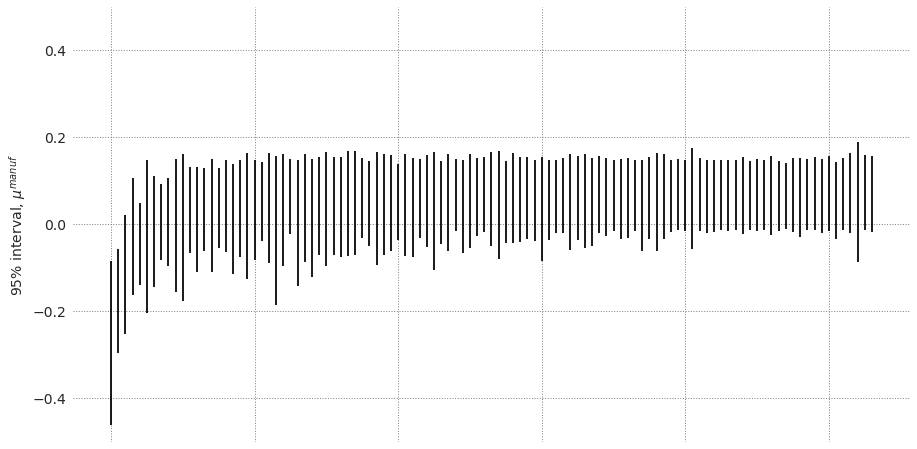

In [37]:
mu_mDF_summ = mu_mDF_summ.sort_values("50%")
mu_mDF_summ["ord"]=[i for i in range(mu_mDF_summ.shape[0])]
fig, ax = plt.subplots()
#ax.fill_between(mu_mDF_summ["ord"], mu_mDF_summ["2.5%"], mu_mDF_summ["97.5%"])
ax.vlines(mu_mDF_summ["ord"], mu_mDF_summ["2.5%"], mu_mDF_summ["97.5%"])
ax.xaxis.set_ticklabels([])
ax.set_ylabel("95% interval, $\mu^{manuf}$")
ax.set_ylim(-.5,.5)
fig.savefig("BayManPlot_const", dpi=300)
plt.show()


### County

In [38]:
#mu_cDF = addseries("mu1_c", solar_extr)


### alpha and beta

In [39]:
b0DF = addseries("b0", solar_extr)
b1DF = addseries("b1", solar_extr)

In [40]:
b0DF.head()

,b00,b01,b02,b03,b04,b05,b06,b07,b08,b09,b010,b011,b012,b013,b014,b015,b016,b017,b018,b019,b020,b021,b022,b023,b024,...,b03120,b03121,b03122,b03123,b03124,b03125,b03126,b03127,b03128,b03129,b03130,b03131,b03132,b03133,b03134,b03135,b03136,b03137,b03138,b03139,b03140,b03141,b03142,b03143,b03144
0,0.156184,-0.442242,0.289254,-0.041056,0.608488,0.574916,-0.297762,-0.405453,-0.251226,-0.352413,-0.148353,0.506886,0.184081,0.163319,-0.451479,2.107221,-0.546620,-0.354151,-0.333779,-0.449280,-0.319512,-0.435096,2.609328,0.532421,-0.130745,...,-0.352800,-0.602771,-0.585647,-0.345835,0.058499,-0.517987,-0.345807,1.815705,0.525190,-0.426593,-0.374928,-0.476397,-0.731406,-0.130256,-0.623439,-0.159509,-0.401170,0.440457,1.587184,-0.742813,1.650729,-0.459514,-0.538942,2.383793,-0.467607
1,0.069899,-0.460714,0.349687,-0.079710,0.583987,0.616076,-0.301899,-0.334671,-0.302926,-0.298895,-0.274734,0.480246,0.184322,0.255426,-0.459358,2.080694,-0.565307,-0.273817,-0.430121,-0.307392,-0.467298,-0.390014,2.505068,0.486844,-0.141266,...,-0.332953,-0.497076,-0.604761,-0.338671,0.033941,-0.551105,-0.397573,1.791607,0.483013,-0.413128,-0.427764,-0.524133,-0.697078,-0.109220,-0.559775,-0.251371,-0.339479,0.431874,1.641489,-0.565109,1.606425,-0.630933,-0.555158,2.274967,-0.520603
2,0.014109,-0.532009,0.306167,0.038569,0.505183,0.550662,-0.317010,-0.410217,-0.290053,-0.294749,-0.160175,0.471852,0.141718,0.136623,-0.461358,2.054548,-0.540035,-0.310214,-0.425494,-0.509416,-0.519672,-0.440994,2.507050,0.447822,-0.155312,...,-0.280249,-0.480498,-0.572097,-0.297037,0.119639,-0.486895,-0.375441,1.833188,0.586984,-0.385827,-0.518422,-0.368942,-0.656011,0.014175,-0.499113,-0.136946,-0.196018,0.531472,1.644221,-0.527720,1.759794,-0.566378,-0.461072,2.331215,-0.442695
3,0.074420,-0.437845,0.331747,-0.007037,0.498129,0.599064,-0.368359,-0.293983,-0.355072,-0.308049,-0.163417,0.396488,0.218416,0.250630,-0.440504,2.126051,-0.569213,-0.267639,-0.426730,-0.394693,-0.438693,-0.450511,2.617847,0.521901,-0.117089,...,-0.268292,-0.489031,-0.603981,-0.327788,0.031076,-0.510075,-0.252427,1.765900,0.616767,-0.484320,-0.437665,-0.442604,-0.696788,0.054369,-0.486506,-0.138105,-0.289255,0.441551,1.637709,-0.705896,1.667788,-0.589622,-0.409788,2.251370,-0.580592
4,0.105656,-0.432409,0.280484,-0.067828,0.596679,0.627001,-0.404834,-0.254498,-0.314207,-0.318536,-0.280642,0.524707,0.136999,0.211330,-0.421087,2.115066,-0.566459,-0.389687,-0.361940,-0.466927,-0.439304,-0.449339,2.560702,0.507349,-0.162837,...,-0.315557,-0.523551,-0.616114,-0.325156,-0.002781,-0.519158,-0.325276,1.750636,0.543808,-0.502265,-0.574565,-0.425993,-0.660327,-0.036286,-0.532462,-0.190301,-0.232882,0.399183,1.634357,-0.648318,1.650077,-0.580026,-0.551641,2.427830,-0.483385


In [41]:
b0DF_summ = b0DF.describe(percentiles=[.025,.975])
b1DF_summ = b1DF.describe(percentiles=[.025,.975])

In [42]:
b0DF_summ = b0DF_summ.transpose()
b1DF_summ = b1DF_summ.transpose()

In [43]:
b0DF_summ.head()

,count,mean,std,min,2.5%,50%,97.5%,max
b00,2000.0,0.000720,0.056089,-0.160579,-0.098261,-0.004704,0.111421,0.175445
b01,2000.0,-0.489935,0.056689,-0.663870,-0.606206,-0.488203,-0.385262,-0.344783
b02,2000.0,0.272117,0.059332,0.111295,0.166375,0.270553,0.397082,0.493167
b03,2000.0,-0.082212,0.053800,-0.240388,-0.173609,-0.085498,0.030410,0.093940
b04,2000.0,0.476860,0.056377,0.324977,0.375457,0.473121,0.596086,0.644379


In [44]:
b0DF_summ.shape[0]


3145

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


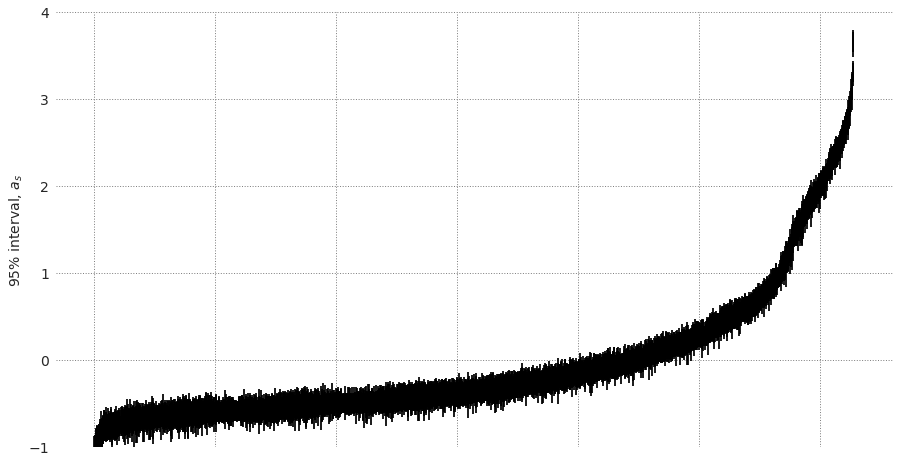

In [45]:
b0DF_summ = b0DF_summ.sort_values("50%")
b0DF_summ["ord"]=[i for i in range(b0DF_summ.shape[0])]
fig, ax = plt.subplots()
#ax.fill_between(b0DF_summ["ord"], b0DF_summ["2.5%"], b0DF_summ["97.5%"])
ax.vlines(b0DF_summ["ord"], b0DF_summ["2.5%"], b0DF_summ["97.5%"])
ax.xaxis.set_ticklabels([])
ax.set_ylabel("95% interval, $a_s$")
ax.set_ylim(-1,4)
fig.savefig("Bay_as_const.png", dpi=300)
plt.show()

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


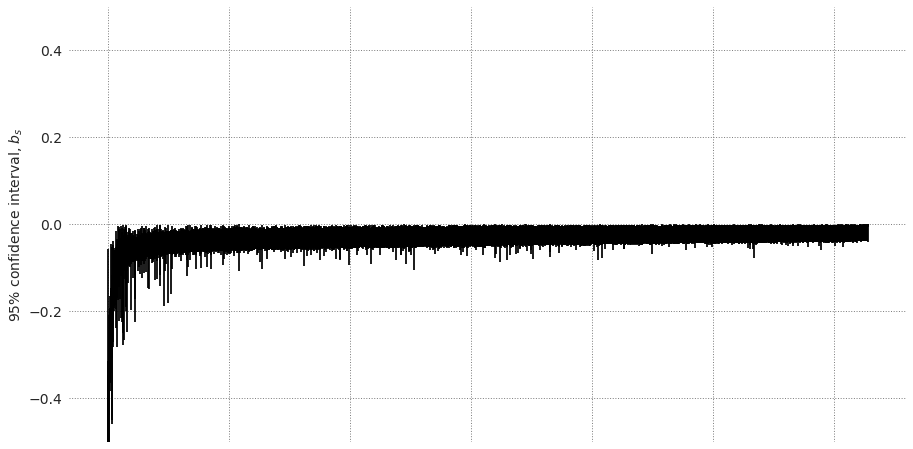

In [46]:
b1DF_summ = b1DF_summ.sort_values("50%")
b1DF_summ["ord"]=[i for i in range(b0DF_summ.shape[0])]
fig, ax = plt.subplots()
ax.vlines(b1DF_summ["ord"], b1DF_summ["2.5%"], b1DF_summ["97.5%"])
#ax.fill_between(b1DF_summ["ord"], b1DF_summ["2.5%"], b1DF_summ["97.5%"])
ax.xaxis.set_ticklabels([])
ax.set_ylabel("95% confidence interval, $b_s$")
ax.set_ylim(-.5,.5)
fig.savefig("Bay_bs_const.png", dpi=300)
plt.show()